# Analysis of results taken from the experimental framework


Analysis needs to answer three specific questions that standard ML metrics don't cover:

- Reliability: Can the model write valid code? (Syntax).

- Accuracy: Does the code actually catch the rule violations? (Logic).

- Stability: Does it solve the problem the same way every time? (Determinism).

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [27]:
# Load Data
df = pd.read_csv("Master_Results.csv")

# Make a new column to denote a match between expected and actual count of violations for scenarios
df['Match'] = df['Expected Violation Count'] == df['Actual Violation Count']


load the "Tidy Data" (Long Format) and create a "Wide Format" version for run-level statistics.

In [28]:
# 1. Create a "Run-Level" Aggregate
# We want one row per Run ID to check overall Syntax/Stability
run_stats = df.groupby("Run ID").agg({
    "SHACL Valid Syntax": "first",     # Did the code compile?
    "SHACL Graph Hash": "first",       # What logic structure was used?
    "Execution Time": "max",           # How long did it take?
    "Match": "mean",                   # % of scenarios passed (Accuracy) 
    "SHACL Error Type": "first"
}).reset_index()

display(run_stats)

# 2. Filter for only Valid Runs for Logic Analysis
valid_runs_df = df[df["SHACL Valid Syntax"] == True]
print(f"Total Runs: {len(run_stats)}")
print(f"Valid Syntax Runs: {len(run_stats[run_stats['SHACL Valid Syntax'] == True])}")

,Run ID,SHACL Valid Syntax,SHACL Graph Hash,Execution Time,Match,SHACL Error Type
0,1,True,12c3549e706983be87cc41bf7db3f344,134.0,0.818182,VALID
1,2,True,6fbf277aef148834d9e6f93bdd39fe7b,111.0,1.000000,VALID
2,3,False,40bfe8291d05a84b4b50e5ffd26b2b61,136.0,0.000000,SPARQL_SYNTAX
3,4,False,389c6e7083760b62714f1195deb39b52,117.0,0.000000,SPARQL_SYNTAX
4,5,True,fe87cddac52ce6f8e869f29fef0caa94,118.0,1.000000,VALID
5,6,True,8401872e9d4c29b54d20154e98f5789a,117.0,0.727273,VALID
6,7,True,d543594f744ec9ffe46976e9a94be2bb,117.0,0.727273,VALID
7,8,True,141338dc39701b85a8e58a65fb156037,187.0,0.818182,VALID
8,9,True,1e79eba459d48f6a37bf83044123c894,125.0,0.818182,VALID
9,10,True,54688cac4b990ca9014de0d68b46d4bc,127.0,0.181818,VALID


Total Runs: 20
Valid Syntax Runs: 9


The "Pipeline Health" Metrics (Syntax & Errors)

C:\Users\Nicklamda\AppData\Local\Temp\ipykernel_10336\1347709469.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.index, y=error_counts.values, palette="viridis")


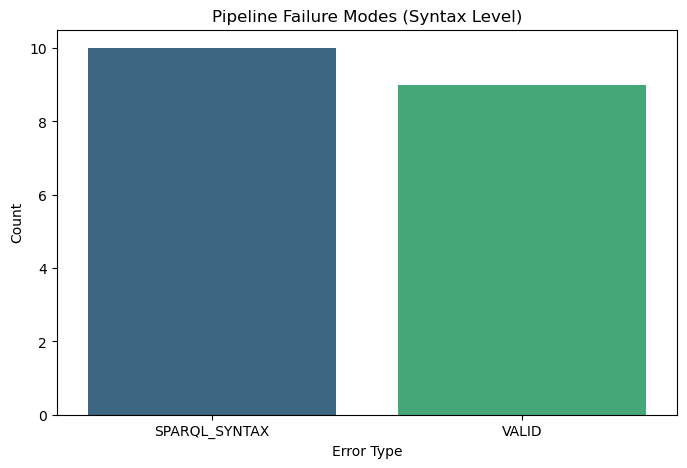

In [29]:
# Count Error Types
error_counts = run_stats["SHACL Error Type"].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=error_counts.index, y=error_counts.values, palette="viridis")
plt.title("Pipeline Failure Modes (Syntax Level)")
plt.ylabel("Count")
plt.xlabel("Error Type")
plt.show()

The "Functional Correctness" (F1 Score / Accuracy)

C:\Users\Nicklamda\AppData\Local\Temp\ipykernel_10336\453799531.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_performance.values, y=scenario_performance.index, palette="RdYlGn")


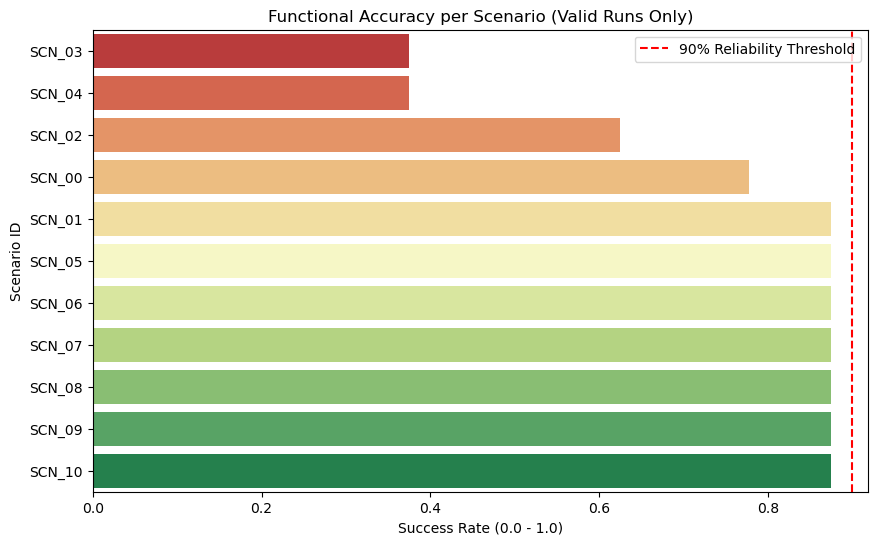

In [30]:
# Group by Scenario ID and calculate the mean of 'Match' (True=1, False=0)
scenario_performance = valid_runs_df.groupby("Scenario ID")["Match"].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=scenario_performance.values, y=scenario_performance.index, palette="RdYlGn")
plt.axvline(x=0.9, color='r', linestyle='--', label='90% Reliability Threshold')
plt.title("Functional Accuracy per Scenario (Valid Runs Only)")
plt.xlabel("Success Rate (0.0 - 1.0)")
plt.legend()
plt.show()

The "Stability" Analysis (The Hash)

Unique Logic Structures Generated: 9
Most Common Structure Frequency: 1


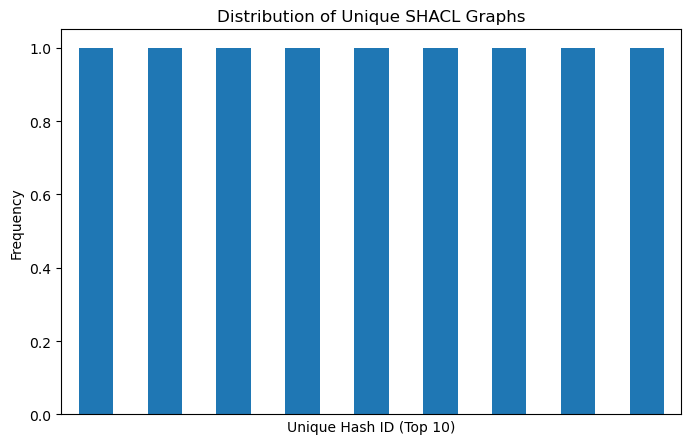

In [31]:
# Count frequency of each unique graph structure
hash_counts = run_stats[run_stats["SHACL Valid Syntax"] == True]["SHACL Graph Hash"].value_counts()

print(f"Unique Logic Structures Generated: {len(hash_counts)}")
print("Most Common Structure Frequency:", hash_counts.iloc[0])

# Visualizing the distribution
plt.figure(figsize=(8, 5))
hash_counts.head(10).plot(kind='bar')
plt.title("Distribution of Unique SHACL Graphs")
plt.xlabel("Unique Hash ID (Top 10)")
plt.ylabel("Frequency")
plt.xticks([]) # Hide ugly hash strings
plt.show()